In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from jet_dataset import JetDataset

from sklearn.metrics import roc_curve
## wrap jet data in dataset

/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from script_jets import *

In [3]:
import pandas as pd
d = pd.read_hdf("./jet_data/filtered_jetclass_test.h5", key="df")

In [4]:
d

,jet_p_top_ParT_full,jet_p_top_ParT_kin,label_top,jet_pt,jet_eta,jet_phi,jet_energy,jet_nparticles,jet_sdmass,jet_tau1,jet_tau2,jet_tau3,jet_tau4,aux_genpart_eta,aux_genpart_phi,aux_genpart_pid,aux_genpart_pt,aux_truth_match
0,9.983645e-01,9.522571e-01,1.0,624.240662,1.129498,-0.465312,1077.869873,52.0,79.332123,0.223729,0.102460,0.055052,0.043698,1.138593,-0.480629,6.0,646.821228,12.0
1,9.999924e-01,9.899870e-01,1.0,607.780273,0.502210,3.009857,708.459656,44.0,176.776321,0.210097,0.075915,0.036901,0.030485,0.495062,3.027341,-6.0,646.858643,11.0
2,9.917580e-01,9.809496e-01,1.0,573.296448,0.820027,-3.040977,794.708008,46.0,166.371460,0.303593,0.076452,0.067617,0.051012,0.802325,-3.031272,6.0,588.094543,12.0
3,9.999778e-01,9.997802e-01,1.0,631.511658,-0.375212,1.492339,697.078247,63.0,166.675827,0.312275,0.194364,0.076688,0.060912,-0.385724,1.499509,6.0,633.465454,12.0
4,9.999519e-01,9.932649e-01,1.0,678.857544,0.937984,1.502388,1016.299377,53.0,181.070892,0.256024,0.117011,0.047009,0.035953,0.927586,1.521285,-6.0,625.966125,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,5.184825e-09,1.588372e-07,0.0,584.750427,0.983164,0.564906,890.911926,9.0,1.410698,0.008389,0.005679,0.003011,0.001487,0.000000,0.000000,0.0,0.000000,50.0
3999996,3.842124e-06,1.341977e-05,0.0,535.355286,0.022202,2.010515,536.581726,32.0,29.710541,0.052328,0.027683,0.022781,0.017210,0.000000,0.000000,0.0,0.000000,50.0
3999997,1.853336e-07,1.424265e-06,0.0,600.248108,-0.925498,1.375982,877.299255,26.0,18.489277,0.050093,0.036496,0.028598,0.022484,0.000000,0.000000,0.0,0.000000,50.0
3999998,1.707080e-04,3.933093e-04,0.0,668.357239,0.436436,-0.924948,735.193542,26.0,52.001625,0.051965,0.021701,0.017412,0.012106,0.000000,0.000000,0.0,0.000000,50.0


In [ ]:
def use_data(k):
    use = not (k=='jet_p_top_ParT_full' or k=='jet_p_top_ParT_kin' or k=='label_top') 
    return use

In [5]:
import numpy as np

(array([1902743.,   40548.,   23626.,   17696.,   15934.,   15887.,
          17701.,   23398.,   41391., 1901076.]),
 array([3.5137035e-10, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

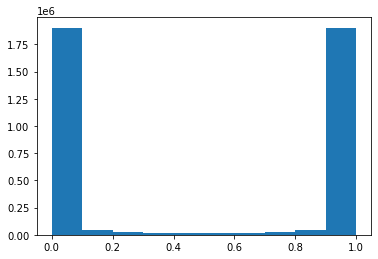

In [6]:
target = np.array(d['jet_p_top_ParT_full'],dtype='float32')[...,np.newaxis]
plt.hist(target)


(array([1.09173e+05, 4.80877e+05, 6.07267e+05, 5.11039e+05, 2.71585e+05,
        2.31147e+05, 6.72679e+05, 9.01002e+05, 2.14401e+05, 8.30000e+02]),
 array([-1.088459  , -0.87599677, -0.6635345 , -0.4510723 , -0.23861007,
        -0.02614784,  0.18631439,  0.39877662,  0.61123884,  0.8237011 ,
         1.0361633 ], dtype=float32),
 <BarContainer object of 10 artists>)

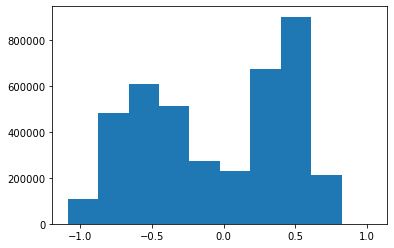

In [7]:
target_prrp = np.log(target/(1.-target + 1e-9))/20. #invert sigmoid
plt.hist(target_prrp)



In [3]:
train_mnist()

epoch 0


loss: 0.0794: 100%|██████████| 977/977 [00:13<00:00, 71.86it/s]



plotting rocsstep 100
plotting raw (1000000, 1) torch.Size([1000000, 1])
plotting raw gen
saved images at ./data/diffusion_jets15/
epoch 1


loss: 0.0752: 100%|██████████| 977/977 [00:12<00:00, 79.71it/s]


epoch 2


loss: 0.0757: 100%|██████████| 977/977 [00:11<00:00, 84.25it/s]


epoch 3


loss: 0.0742: 100%|██████████| 977/977 [00:11<00:00, 82.41it/s]


epoch 4


loss: 0.0744: 100%|██████████| 977/977 [00:11<00:00, 86.55it/s]


epoch 5


loss: 0.0725: 100%|██████████| 977/977 [00:12<00:00, 78.06it/s]


epoch 6


loss: 0.0740: 100%|██████████| 977/977 [00:12<00:00, 78.84it/s]


epoch 7


loss: 0.0741: 100%|██████████| 977/977 [00:11<00:00, 82.24it/s]


epoch 8


loss: 0.0753: 100%|██████████| 977/977 [00:11<00:00, 82.45it/s]


epoch 9


loss: 0.0737: 100%|██████████| 977/977 [00:12<00:00, 76.79it/s]


epoch 10


loss: 0.0735: 100%|██████████| 977/977 [00:12<00:00, 80.39it/s]


epoch 11


loss: 0.0737: 100%|██████████| 977/977 [00:11<00:00, 85.84it/s]


epoch 12


loss: 0.0724: 100%|██████████| 977/977 [00:12<00:00, 80.66it/s]


epoch 13


loss: 0.0740: 100%|██████████| 977/977 [00:12<00:00, 78.71it/s]


epoch 14


loss: 0.0743: 100%|██████████| 977/977 [00:12<00:00, 80.40it/s]


epoch 15


loss: 0.0722: 100%|██████████| 977/977 [00:12<00:00, 79.17it/s]


epoch 16


loss: 0.0731: 100%|██████████| 977/977 [00:12<00:00, 80.70it/s]


epoch 17


loss: 0.0737: 100%|██████████| 977/977 [00:11<00:00, 84.91it/s]


epoch 18


loss: 0.0717: 100%|██████████| 977/977 [00:11<00:00, 88.30it/s] 


epoch 19


loss: 0.0736: 100%|██████████| 977/977 [00:13<00:00, 74.71it/s]



plotting rocsstep 100
plotting raw (1000000, 1) torch.Size([1000000, 1])
plotting raw gen
saved images at ./data/diffusion_jets15/
epoch 20


loss: 0.0725: 100%|██████████| 977/977 [00:12<00:00, 76.71it/s]


epoch 21


loss: 0.0727: 100%|██████████| 977/977 [00:12<00:00, 78.49it/s]


epoch 22


loss: 0.0729: 100%|██████████| 977/977 [00:12<00:00, 79.82it/s]


epoch 23


loss: 0.0716: 100%|██████████| 977/977 [00:12<00:00, 80.90it/s]


epoch 24


loss: 0.0715: 100%|██████████| 977/977 [00:11<00:00, 83.69it/s]


epoch 25


loss: 0.0714: 100%|██████████| 977/977 [00:11<00:00, 84.24it/s]


epoch 26


loss: 0.0710: 100%|██████████| 977/977 [00:13<00:00, 74.04it/s]


epoch 27


loss: 0.0704: 100%|██████████| 977/977 [00:12<00:00, 80.48it/s]


epoch 28


loss: 0.0702: 100%|██████████| 977/977 [00:12<00:00, 77.19it/s]


epoch 29


loss: 0.0708: 100%|██████████| 977/977 [00:11<00:00, 83.45it/s]


epoch 30


loss: 0.0709: 100%|██████████| 977/977 [00:12<00:00, 77.04it/s]


epoch 31


loss: 0.0712: 100%|██████████| 977/977 [00:12<00:00, 78.07it/s]


epoch 32


loss: 0.0702: 100%|██████████| 977/977 [00:12<00:00, 79.63it/s]


epoch 33


loss: 0.0711: 100%|██████████| 977/977 [00:12<00:00, 80.66it/s]


epoch 34


loss: 0.0697: 100%|██████████| 977/977 [00:12<00:00, 81.29it/s]


epoch 35


loss: 0.0721: 100%|██████████| 977/977 [00:12<00:00, 81.22it/s]


epoch 36


loss: 0.0702: 100%|██████████| 977/977 [00:13<00:00, 73.90it/s]


epoch 37


loss: 0.0717: 100%|██████████| 977/977 [00:10<00:00, 88.99it/s] 


epoch 38


loss: 0.0715: 100%|██████████| 977/977 [00:11<00:00, 85.19it/s]


epoch 39


loss: 0.0724: 100%|██████████| 977/977 [00:11<00:00, 87.72it/s] 



plotting rocsstep 100
plotting raw (1000000, 1) torch.Size([1000000, 1])
plotting raw gen
saved images at ./data/diffusion_jets15/
epoch 40


loss: 0.0708: 100%|██████████| 977/977 [00:11<00:00, 81.69it/s]


epoch 41


loss: 0.0702: 100%|██████████| 977/977 [00:11<00:00, 84.72it/s] 


epoch 42


loss: 0.0714: 100%|██████████| 977/977 [00:12<00:00, 76.43it/s]


epoch 43


loss: 0.0714: 100%|██████████| 977/977 [00:12<00:00, 81.22it/s]


epoch 44


loss: 0.0710: 100%|██████████| 977/977 [00:11<00:00, 82.86it/s] 


epoch 45


loss: 0.0703: 100%|██████████| 977/977 [00:11<00:00, 85.74it/s] 


epoch 46


loss: 0.0695: 100%|██████████| 977/977 [00:11<00:00, 82.61it/s] 


epoch 47


loss: 0.0709: 100%|██████████| 977/977 [00:11<00:00, 83.27it/s]


epoch 48


loss: 0.0709: 100%|██████████| 977/977 [00:13<00:00, 73.20it/s]


epoch 49
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


loss: 0.0713: 100%|██████████| 977/977 [00:11<00:00, 86.42it/s] 


epoch 50
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


loss: 0.0705: 100%|██████████| 977/977 [00:11<00:00, 83.93it/s] 


epoch 51
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


loss: 0.0705: 100%|██████████| 977/977 [00:12<00:00, 81.14it/s]


epoch 52
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


loss: 0.0706: 100%|██████████| 977/977 [00:12<00:00, 78.25it/s]


epoch 53
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


loss: 0.0705: 100%|██████████| 977/977 [00:12<00:00, 80.83it/s]


epoch 54
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


loss: 0.0706: 100%|██████████| 977/977 [00:11<00:00, 81.73it/s]


epoch 55
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


loss: 0.0686: 100%|██████████| 977/977 [00:12<00:00, 79.94it/s]


epoch 56
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


loss: 0.0697: 100%|██████████| 977/977 [00:11<00:00, 84.32it/s]


epoch 57
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


loss: 0.0696: 100%|██████████| 977/977 [00:12<00:00, 79.45it/s]


epoch 58
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


loss: 0.0693: 100%|██████████| 977/977 [00:11<00:00, 85.17it/s] 


epoch 59
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
froze BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


loss: 0.0710: 100%|██████████| 977/977 [00:11<00:00, 86.36it/s] 



plotting rocsstep 100
plotting raw (1000000, 1) torch.Size([1000000, 1])
plotting raw gen
saved images at ./data/diffusion_jets15/
saved model at ./data/diffusion_jets15/model_59.pth


In [4]:
inject_output()

(4000000, 16)
predicting

saving.... can take a moment
done
